### Base imports

In [12]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [53]:
#base imports
from fastai.conv_learner import *
from fastai.plots import *
from fastai.imports import *
from fastai.transforms import *
from fastai.dataset import *
from sklearn.metrics import fbeta_score
import warnings

### Getting the data

In [21]:
PATH = 'data/fruits-360'

In [22]:
ls {PATH}

LICENSE  papers/  readme.md  Test/  test-multiple_fruits/  Training/


### Data analysis

In [47]:
def get_1st(path, label): 
    return glob(f'{path}/{label}/*.jpg*')[0]

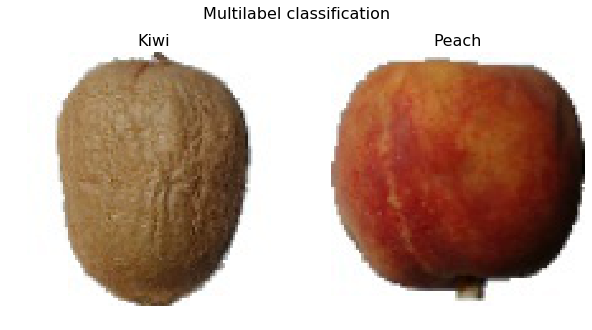

In [50]:
path_from_files = [get_1st(f'{PATH}/Training', 'Kiwi'), get_1st(f'{PATH}/Training', 'Peach')]
titles = ['Kiwi', 'Peach']
plots_from_files(path_from_files ,maintitle='Multilabel classification',titles=titles)

### Model for our dataset

In [52]:
# planet.py

def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

In [54]:
metrics=[f2]
f_model=resnet34

### Import dataset

In [87]:
import glob
import cv2

training_fruit_img = []
training_label = []
for dir_path in glob.glob(f'{PATH}/Training/*'):
    img_label = dir_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(dir_path, "*.jpg")):
        img = cv2.imread(img_path)
        training_fruit_img.append(img)
        training_label.append(img_label)
training_fruit_img = np.array(training_fruit_img)
training_label = np.array(training_label)
len(np.unique(training_label))

93

In [111]:
#get id: label data
label_id_dict = {v:i for i,v in enumerate(np.unique(training_label))}
label_ids = np.array([label_id_dict[x] for x in training_label])
label_ids.shape , training_label.shape

In [121]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.05)
    return ImageClassifierData.from_paths(PATH, trn_name='Training',  tfms=tfms, val_name='Test')

In [122]:
data = get_data(256)

In [129]:
x,y = next(iter(data.val_dl))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


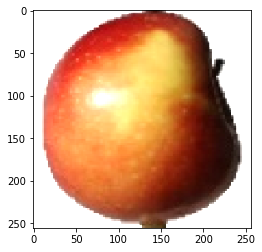

In [137]:
plt.imshow(data.val_ds.denorm(to_np(x))[54]*1.4)

### Find a learning rate and fit our model

In [174]:
sz=128
data = data.resize(int(sz*1.3), '/tmp')

In [175]:
arch = resnet34

In [176]:
learn = ConvLearner.pretrained(arch,data, precompute=True)

100%|██████████| 250/250 [00:53<00:00,  5.66it/s]


In [177]:
lrf=learn.lr_find()

 80%|████████  | 597/744 [00:10<00:04, 32.67it/s, loss=0.971]

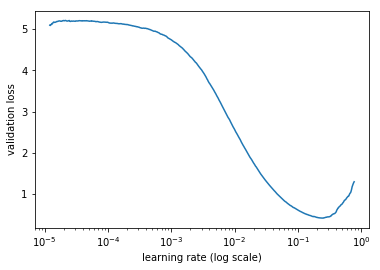

In [178]:
learn.sched.plot()

In [179]:
lr = 10e-2
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.04215    0.078296   0.984664  
    1      0.049341   0.063049   0.987731                     
    2      0.04598    0.054234   0.987919                     


[array([0.05423]), 0.9879186228482003]

In [180]:
lrs = np.array([lr/9,lr/3,lr])

In [181]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.032917   0.037023   0.989358  
    1      0.028663   0.037098   0.989296                     
    2      0.02016    0.032337   0.991174                     
    3      0.021053   0.035276   0.991049                     
    4      0.023907   0.032784   0.991674                     
    5      0.012873   0.027354   0.993239                      
    6      0.01178    0.027309   0.993114                      


[array([0.02731]), 0.993114241001565]

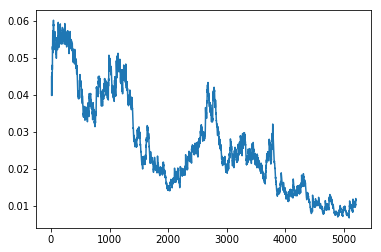

In [188]:
learn.sched.plot_loss()

In [189]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)

In [190]:
preds

array([ 0,  0,  0, ..., 92, 92, 92])

In [191]:
probs = np.exp(log_preds[:,1])

### Take a look on our results

In [202]:
training_path = f'{PATH}/'

def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): return np.array(PIL.Image.open(training_path+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correct Predictions


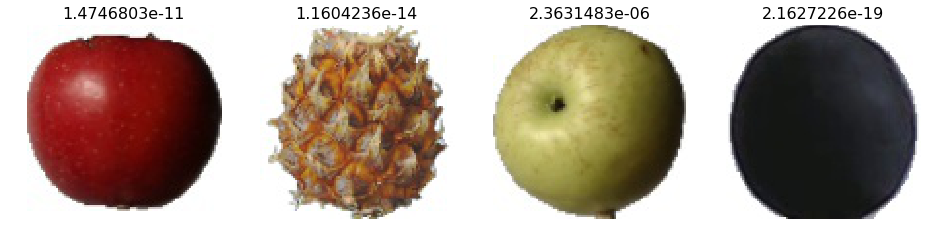

In [203]:
plot_val_with_title(rand_by_correct(True), "Correct Predictions")


In [204]:
def  most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most Correct Banana Lady Finger


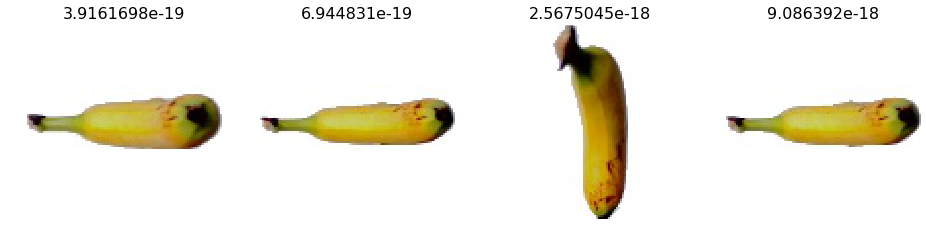

In [210]:
i = 15
plot_val_with_title(most_by_correct(i,True), "Most Correct " + data.classes[i])

Most CorrectCarambula


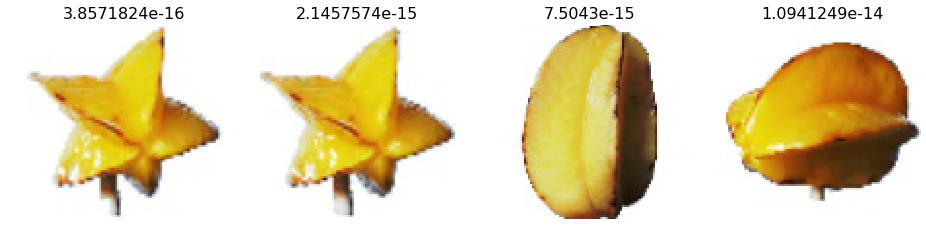

In [211]:
i = 20
plot_val_with_title(most_by_correct(i,True), "Most Correct" + data.classes[i])